In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from upsetplot import from_contents, plot
from matplotlib import pyplot

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from dfmodel import DigitalFamilyBinary

# Set the font to Arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
design_matrix_test = pd.read_csv(
    "design_matrix_test_predictions.tsv",
    sep='\t'
)

In [3]:
design_matrix_val = pd.read_csv(
    "design_matrix_val_predictions.tsv",
    sep='\t'
)

In [4]:
probability_columns = [
    col for col in design_matrix_test.columns if "probability" in col #and "sofa" not in col
]
probability_columns

['resp_probability',
 'coag_probability',
 'liver_probability',
 'cns_probability',
 'renal_probability',
 'cardiovasc_probability']

In [5]:
clinical_columns = [
    "sao2_ambulance",
    #"oxygen_treatment_ambulance", # categorical
    #"oxygene_l_per_min_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    #"diast_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance", # categorical
    #"is_the_mental_status_impaired_ambulance", # categorical
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    #"diast_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    #"oxygen_treatment_ambulance", # categorical
    "mental_status_ambulance", # categorical,
    #"sex",
    #"is_the_mental_status_impaired_ambulance", # categorical
]

In [6]:
X = design_matrix_test.copy()
X_test = design_matrix_val.copy()

In [7]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

clinical_scaler = StandardScaler()
probability_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

X[continuous_clinical_columns] = clinical_imputer.fit_transform(X[continuous_clinical_columns])
X[categorical_clinical_columns] = constant_imputer.fit_transform(X[categorical_clinical_columns])

X[continuous_clinical_columns] = clinical_scaler.fit_transform(X[continuous_clinical_columns])
X[probability_columns] = probability_scaler.fit_transform(X[probability_columns])


X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])
X_test[probability_columns] = probability_scaler.transform(X_test[probability_columns])


In [8]:
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_results(X_input, bootstrap_data):

    bootstrap_counts = []


    for bootstrap_iteration in list(bootstrap_data.keys()):


        mort_range = X_input[bootstrap_iteration].unique()
        mort_range.sort()
        actual_mort = []
        #mort_range = mort_range[:-1]
        counts_per_bin = []
        for val in mort_range:

            counts = X_input[X_input[bootstrap_iteration] == val]['sepsis_or_septic_shock'].value_counts()
            actual_mort.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
            counts_per_bin.append(counts.sum())

        estimated_mort = pd.DataFrame(
            {
                "Actual Sepsis Rate": actual_mort,
                "Estimated Sepsis Rate": mort_range,
                "Counts": counts_per_bin
            }
        )

        bootstrap_counts.append(estimated_mort)

    estimated_sepsis = pd.concat(bootstrap_counts)

    # linreg = LinearRegression()

    # linreg.fit(estimated_sepsis[['Estimated Sepsis Rate']], estimated_sepsis[['Actual Sepsis Rate']])

    linregress_results = linregress(estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel())
    
    predictions = linregress_results.intercept + linregress_results.slope*estimated_sepsis[['Estimated Sepsis Rate']].values.ravel()

    corr, pval = pearsonr(
        estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel()
    )

    return estimated_sepsis, linregress_results, predictions, corr, pval

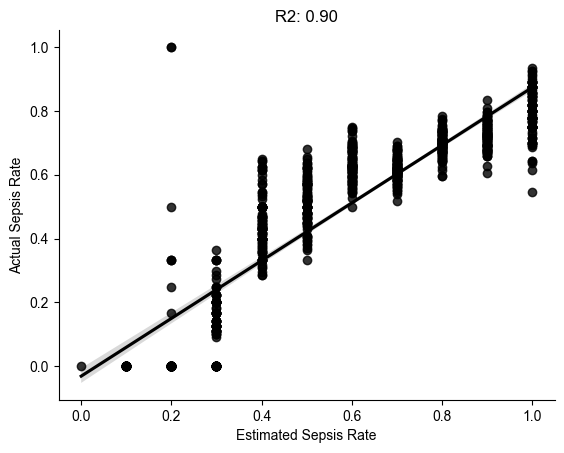

In [9]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(X, features=probability_columns)
X_test['Sepsis Protein Prob'] = df_estimator.predict(
    X_test[probability_columns], 
    features=probability_columns, 
    target_column="sepsis_or_septic_shock"
)

X_test_results = pd.concat([design_matrix_val,  df_estimator.bootstrap_results_df], axis=1)

fig, ax = plt.subplots()

protein_estimated_sepsis, protein_linregress_results, protein_predictions, protein_corr, protein_pval = plot_results(X_test_results, df_estimator.bootstrap_results_df)


sns.regplot(
    data=protein_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {protein_linregress_results.rvalue:.2f}"
)

sns.despine()

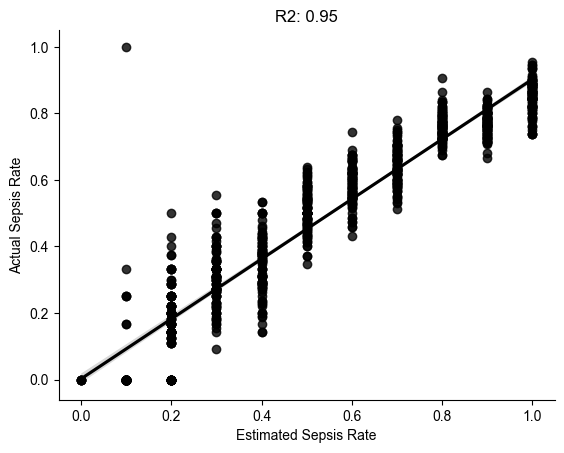

In [10]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(X, features=clinical_columns)
X_test['Sepsis Protein Prob'] = df_estimator.predict(
    X_test[clinical_columns], 
    features=clinical_columns, 
    target_column="sepsis_or_septic_shock"
)

X_test_results = pd.concat([design_matrix_val,  df_estimator.bootstrap_results_df], axis=1)

fig, ax = plt.subplots()

clinical_estimated_sepsis, clinical_linregress_results, clinical_predictions, clinical_corr, clinical_pval = plot_results(X_test_results, df_estimator.bootstrap_results_df)


sns.regplot(
    data=clinical_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {clinical_linregress_results.rvalue:.2f}"
)

sns.despine()

In [11]:

clinical_columns.extend(probability_columns)
clinical_columns

['sao2_ambulance',
 'resp_frequency_ambulance',
 'heart_rate_ambulance',
 'syst_bp_ambulance',
 'map_ambulance',
 'mental_status_ambulance',
 'temperature_ambulance',
 'crea_emergency_department',
 'bili_emergency_department',
 'crp_day1',
 'trc_emergency_department',
 'sex',
 'age',
 'resp_probability',
 'coag_probability',
 'liver_probability',
 'cns_probability',
 'renal_probability',
 'cardiovasc_probability']

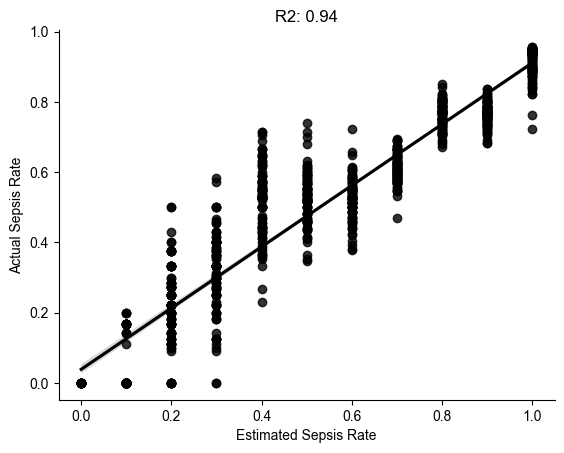

In [12]:
df_estimator = DigitalFamilyBinary()

df_estimator.fit(X, features=clinical_columns)
X_test['Sepsis Protein Prob'] = df_estimator.predict(
    X_test[clinical_columns], 
    features=clinical_columns, 
    target_column="sepsis_or_septic_shock"
)

X_test_results = pd.concat([design_matrix_val,  df_estimator.bootstrap_results_df], axis=1)

fig, ax = plt.subplots()

combined_estimated_sepsis, combined_linregress_results, combined_predictions, combined_corr, combined_pval = plot_results(X_test_results, df_estimator.bootstrap_results_df)

sns.regplot(
    data=combined_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {combined_linregress_results.rvalue:.2f}"
)

sns.despine()

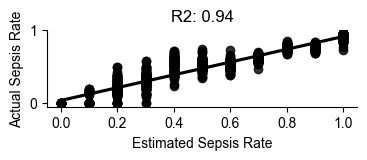

In [13]:
fig, ax = plt.subplots()

sns.regplot(
    data=combined_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax,
    color="k"
)

ax.set_title(
    f"R2: {combined_linregress_results.rvalue:.2f}"
)

fig.set_size_inches((4, 1))

sns.despine()

In [14]:
protein_estimated_sepsis['Label'] = "Protein"
clinical_estimated_sepsis['Label'] = "Clinical"
combined_estimated_sepsis['Label'] = "Combined"

In [15]:
protein_estimated_sepsis['Predictions'] = protein_predictions
clinical_estimated_sepsis['Predictions'] = clinical_predictions
combined_estimated_sepsis['Predictions'] = combined_predictions
combined_estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Counts,Label,Predictions
0,0.000000,0.0,3,Combined,0.038700
1,0.000000,0.1,6,Combined,0.125908
2,0.375000,0.2,8,Combined,0.213117
3,0.250000,0.3,12,Combined,0.300325
4,0.647059,0.4,17,Combined,0.387533
...,...,...,...,...,...
5,0.526316,0.6,38,Combined,0.561949
6,0.645833,0.7,48,Combined,0.649157
7,0.730769,0.8,52,Combined,0.736365
8,0.785714,0.9,42,Combined,0.823574


In [16]:
estimated_sepsis = pd.concat(
    [
        protein_estimated_sepsis,
        clinical_estimated_sepsis,
        combined_estimated_sepsis
    ]
)
estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Counts,Label,Predictions
0,0.000000,0.1,1,Protein,0.059780
1,0.000000,0.3,8,Protein,0.240453
2,0.650000,0.4,20,Protein,0.330790
3,0.535714,0.5,28,Protein,0.421127
4,0.595745,0.6,47,Protein,0.511464
...,...,...,...,...,...
5,0.526316,0.6,38,Combined,0.561949
6,0.645833,0.7,48,Combined,0.649157
7,0.730769,0.8,52,Combined,0.736365
8,0.785714,0.9,42,Combined,0.823574


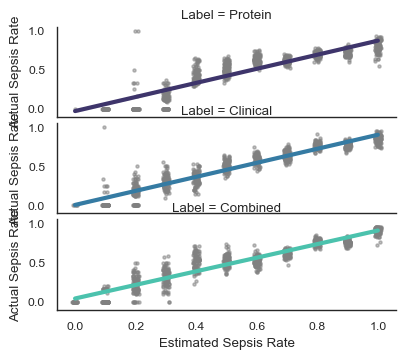

In [17]:
#fig, ax = plt.subplots()

sns.set_theme(context="paper", style="white")

g = sns.lmplot(
    data=estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    hue="Label",
    row="Label",
    ci=95,
    palette="mako",
    scatter_kws={"color": "gray", "alpha": 0.5, "s": 5},
    line_kws={"lw": "3"},
    #scatter_kws={'alpha': 0.1, 's': 5},
    scatter=True,
    x_ci=95,
    x_jitter=0.01,
    #s=100,
    #ax=ax
)

# sns.lineplot(
#     data=estimated_sepsis,
#     x='Estimated Sepsis Rate',
#     y="Predictions",
#     hue="Label",
#     palette="mako",
#     lw=2,
#     ax=ax
# )

#g.axes[0].axline((0, 0), slope=1, color='k', linestyle='--')

sns.despine()

# ax.set_title(
#     f"R2: {combined_linregress_results.rvalue:.2f}\n
#     "
# )

g.figure.set_size_inches((4, 3))



In [18]:
g.figure.savefig(
    "digital_family_sepsis_organ_dysfunction.pdf", dpi=300, bbox_inches="tight"
)

In [19]:
estimated_sepsis.to_csv(
    "digital_family_sepsis_organ_dysfunction.tsv",
    sep="\t",
    index=False
)